In [3]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
# pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

In [72]:
df = pd.read_csv("Data\\data_preprocessed\\taiwan_data_binned.csv", sep=",", na_values="NULL")

X = df.drop(["GOOD"], axis=1)
y = df["GOOD"]

df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GOOD
0,1,2,2,1,1,2,2,-1,-1,-2,...,1,1,1,1,2,1,1,1,1,0
1,5,2,2,2,2,-1,2,0,0,0,...,3,3,4,1,2,2,2,1,3,0
2,4,2,2,2,5,0,0,0,0,0,...,5,5,5,2,2,2,2,2,4,1
3,2,2,2,1,6,0,0,0,0,0,...,6,7,7,3,3,2,2,2,2,1
4,2,1,2,1,10,-1,0,-1,0,0,...,6,6,6,3,5,5,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,8,1,3,1,7,0,0,0,0,0,...,9,7,5,5,5,4,3,4,2,1
29996,6,1,3,2,8,-1,-1,-1,-1,0,...,4,4,1,3,4,5,1,1,1,1
29997,1,1,2,2,6,4,3,2,-1,0,...,6,6,6,1,1,5,4,3,3,0
29998,4,1,3,1,8,1,-1,0,0,0,...,8,5,8,5,4,2,3,4,3,0


In [74]:
encoder = WOEEncoder(cols=X.columns)
encoder.fit(X, y)

encoder.transform(X).head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.676851,0.079796,-0.091407,-0.076823,-0.247134,-2.064535,-1.483906,0.429365,0.406626,0.146619,...,-0.011668,-0.063876,-0.101678,-0.054590,-0.605285,-0.109019,-0.519484,-0.381492,-0.332081,-0.350377
1,-0.042830,0.079796,-0.091407,0.070559,0.082730,0.342132,-1.483906,0.295227,0.235501,0.200886,...,0.107955,0.149203,0.158078,0.313852,-0.605285,-0.109019,-0.040077,-0.095252,-0.332081,0.084080
2,-0.135227,0.079796,-0.091407,0.070559,0.167216,0.658825,0.405975,0.295227,0.235501,0.200886,...,-0.158970,-0.108127,-0.073599,-0.039862,-0.034394,-0.109019,-0.040077,-0.095252,-0.093755,0.487439
3,-0.273433,0.079796,-0.091407,-0.076823,0.021680,0.658825,0.405975,0.295227,0.235501,0.200886,...,0.031509,-0.149164,-0.108566,-0.146490,0.018956,0.043052,-0.040077,-0.095252,-0.093755,-0.110346
4,-0.273433,-0.115175,-0.091407,-0.076823,-0.176691,0.342132,0.405975,0.429365,0.235501,0.200886,...,-0.075890,-0.149164,-0.174904,-0.215064,0.018956,0.627978,0.508244,0.470183,-0.093755,-0.110346


### Feature selection

In [75]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
sfs = SequentialFeatureSelector(
    LogisticRegression(),
    k_features=15,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(encoder.transform(X), y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    4.5s finished

[2021-04-26 23:12:45] Features: 1/15 -- score: 0.712432000869678[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-04-26 23:12:47] Features: 2/15 -- score: 0.7447809584719719[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2021-04-26 23:12:49] Features: 3/15 -- score: 0.753800506722268[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent wo

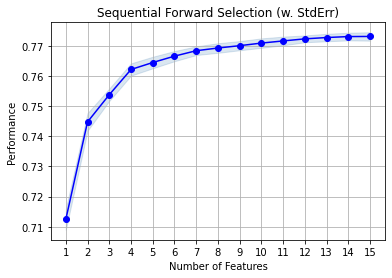

In [76]:
# print chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err")
plt.title("Sequential Forward Selection (w. StdErr)")
plt.grid()
plt.show()

In [77]:
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
results["avg_score"] = results["avg_score"] * 2 - 1
results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[0.7207472870935798, 0.7141369611797704, 0.711...",0.424864,"(PAY_0,)",0.008948,0.006962,0.003481
2,"(0, 5)","[0.7563483815398581, 0.7433831188193136, 0.740...",0.489562,"(LIMIT_BAL, PAY_0)",0.007532,0.00586,0.00293
3,"(0, 5, 18)","[0.7616412245729496, 0.7534609747251724, 0.749...",0.507601,"(LIMIT_BAL, PAY_0, PAY_AMT2)",0.005282,0.004109,0.002055
4,"(0, 5, 8, 18)","[0.769925888270548, 0.7609124294819395, 0.7581...",0.524342,"(LIMIT_BAL, PAY_0, PAY_4, PAY_AMT2)",0.00522,0.004062,0.002031
5,"(0, 5, 8, 17, 18)","[0.7720616251392557, 0.7626852683996039, 0.761...",0.528965,"(LIMIT_BAL, PAY_0, PAY_4, PAY_AMT1, PAY_AMT2)",0.00491,0.00382,0.00191
6,"(0, 5, 8, 13, 17, 18)","[0.7733038049028305, 0.7642580612284555, 0.765...",0.5332,"(LIMIT_BAL, PAY_0, PAY_4, BILL_AMT3, PAY_AMT1,...",0.004332,0.003371,0.001685
7,"(0, 5, 8, 10, 13, 17, 18)","[0.7740172483598778, 0.76649880319061, 0.76781...",0.536799,"(LIMIT_BAL, PAY_0, PAY_4, PAY_6, BILL_AMT3, PA...",0.003683,0.002866,0.001433
8,"(0, 3, 5, 8, 10, 13, 17, 18)","[0.7751055054980196, 0.7661058065614795, 0.768...",0.538587,"(LIMIT_BAL, MARRIAGE, PAY_0, PAY_4, PAY_6, BIL...",0.004077,0.003172,0.001586
9,"(0, 3, 5, 8, 10, 13, 17, 18, 20)","[0.7757224048161826, 0.7674172735645182, 0.769...",0.540143,"(LIMIT_BAL, MARRIAGE, PAY_0, PAY_4, PAY_6, BIL...",0.003913,0.003044,0.001522
10,"(0, 3, 5, 7, 8, 10, 13, 17, 18, 20)","[0.7767695621957006, 0.7683928308513159, 0.771...",0.541862,"(LIMIT_BAL, MARRIAGE, PAY_0, PAY_3, PAY_4, PAY...",0.004016,0.003124,0.001562


In [78]:
final_variables = list(results["feature_names"][11])
final_variables

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_3',
 'PAY_4',
 'PAY_6',
 'BILL_AMT3',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT4']

### Final model

In [79]:
X = X[final_variables]
X = X[final_variables]

pipe = Pipeline([("scaler", WOEEncoder()), ("lr", LogisticRegression())])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    pipe, X, y, scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)

In [80]:
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.476
GINI dev: 0.474 (0.011)
